In [3]:
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
import bayespy 

import pymc3 as pm
import arviz as az

# pd.set_option('display.max_columns', None)

from utils import *

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

#%load_ext watermark
#%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import scipy.stats as scs
from scipy.stats import norm
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

### Loading Data

In [20]:
data = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_data.csv')

In [21]:
data.head()

,TV_MONDAY,TV_TUESDAY,TV_WEDNESDAY,TV_THURSDAY,TV_FRIDAY,TV_SATURDAY,TV_SUNDAY,TOTAL_CONV
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
1,10.0,15.0,16.0,20.0,31.0,23.0,9.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0


In [79]:
# Filter the rows where sum of the values = 0
data = data[data.iloc[:,:-1].sum(axis=1)!=0]

# Select only with CONV RATE > 0  & (data['TOTAL_CONV']<500)
data = data.loc[data['TOTAL_CONV']>0] 

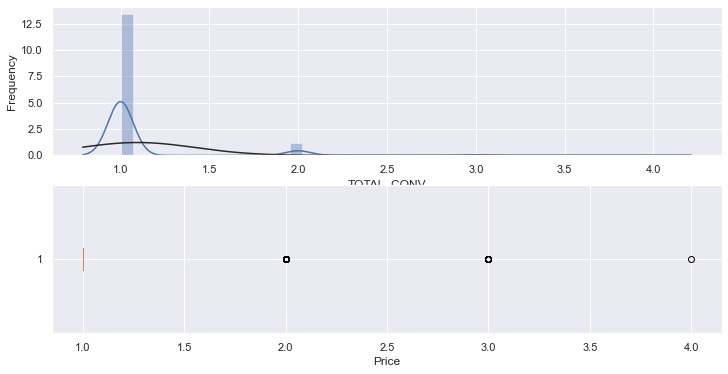

In [157]:
target_distribution(data.TOTAL_CONV)

# Bayesian Multiple Linear Regression

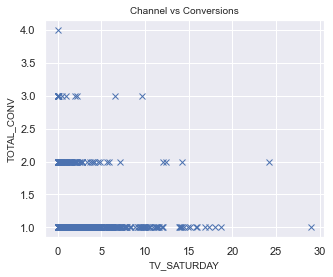

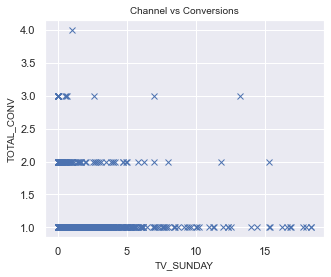

In [81]:
plot_relationship(data.iloc[:,-3:], 'TOTAL_CONV')

In [10]:
# model_formula = 'Conver = '
# for variable in normal_trace_normal.varnames:
#     model_formula += ' %0.2f * %s +' % (np.mean(normal_trace_normal[variable]), variable)
# ' '.join(model_formula.split(' ')[:-1])

## Building Model With Normaly Distributed Priors and Likelyhood (Based Line Model)

In [82]:
x = data.iloc[:,:-1].values
y = data.TOTAL_CONV.values

In [83]:
with pm.Model() as model_mlr_normal:
    
    # Intercept
    alpha = pm.Normal('alpha', mu=0, sd=5)
    
    # Slope
    beta = pm.Normal('beta', mu=0, sd =5, shape = len(data.columns[:-1]))
    
    # Error term
    eps = pm.HalfCauchy('eps', 4)
    
    # Expected value of outcome (MLR with vectors)
    mu = alpha + pm.math.dot(x, beta)
    
    # Likelihood
    conversion = pm.Normal('conversion', mu= mu, sd= eps, observed= y)
    
    # posterior/create the race
    trace_normal = pm.sample(chains = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.


In [84]:
# pm.model_to_graphviz(model_mlr_normal)

## Convergency checks
In this model, we use ArviZ to check if our model has converged.

We want to have a good agreement btw 4 chains which indicates that Sampling process went smoothly

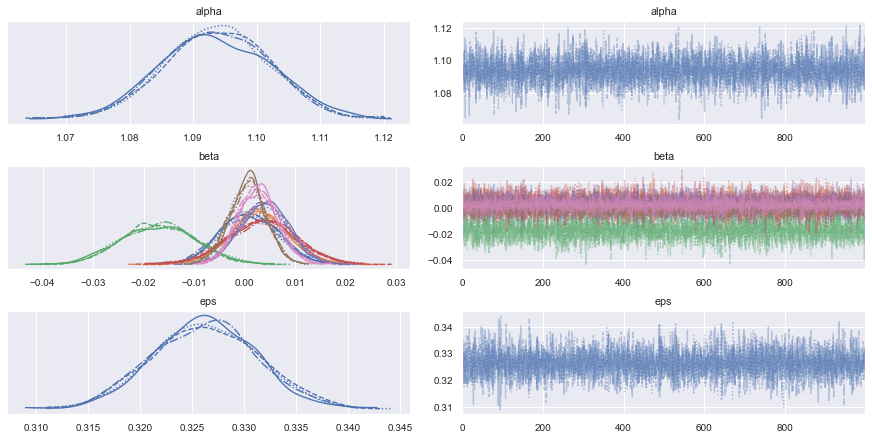

In [85]:
az.plot_trace(trace_normal)
plt.show()

In [86]:
# Lets look at slopes coefficients
az.summary(trace_normal, var_names = 'beta').set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TV_MONDAY,0.001,0.006,-0.010,0.011,0.0,0.0,5706.0,2937.0,1.0
TV_TUESDAY,0.003,0.006,-0.008,0.014,0.0,0.0,5528.0,2616.0,1.0
TV_WEDNESDAY,-0.017,0.007,-0.030,-0.003,0.0,0.0,6356.0,2946.0,1.0
TV_THURSDAY,0.003,0.007,-0.010,0.016,0.0,0.0,6115.0,2649.0,1.0
TV_FRIDAY,0.004,0.005,-0.005,0.013,0.0,0.0,6684.0,3385.0,1.0
TV_SATURDAY,0.001,0.004,-0.006,0.007,0.0,0.0,6619.0,3112.0,1.0
TV_SUNDAY,0.003,0.004,-0.004,0.010,0.0,0.0,5900.0,3358.0,1.0


In [87]:
# Lets look at the slope and error
az.summary(trace_normal, var_names = 'alpha')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.094,0.008,1.078,1.109,0.0,0.0,6646.0,3138.0,1.0


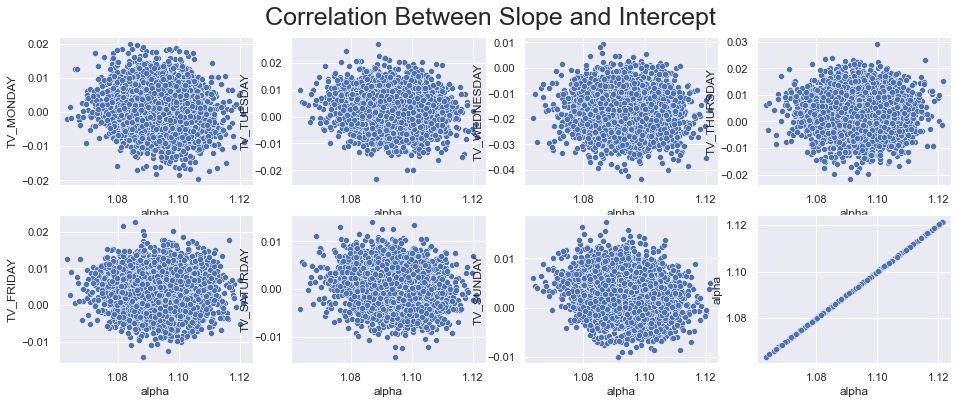

In [88]:
# Checking for correlation between slope and intercepts
plot_correlation(trace_normal, data)

In [89]:
# g = sns.PairGrid(df)
# g.map(sns.scatterplot)
# plt.show()

    Rhat statistic
The Rhat statistic measures how similar the different chains are. So to be able to compute it, we need at least two chains. If all chains converged to the same distribution, then the Rhat statistic should be close to 1.
An Rhat greater than 1.1 means something is very wrong and your model did not converge (in this case, PyMC3 will also raise some warnings). However, already a value above 1.01 is reason for concern, so when computing it via the summary function from ArviZ, it is best to deactive rounding.

The following parameters have an Rhat greater 1.01:


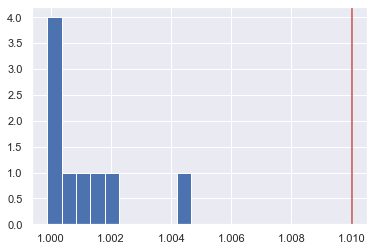

In [90]:
check_rhat(trace_normal, 1.01)

    Energy Distribution related to MCMC sampling that proposing different energy levels. We want our Margin plot be as wide as Energy plot. (They should be close to each other)

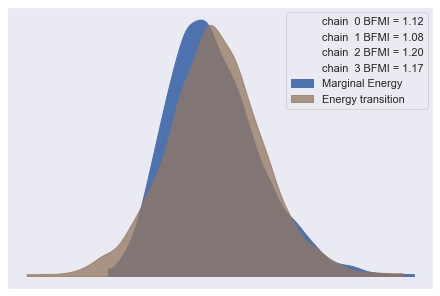

In [91]:
az.plot_energy(trace_normal)
plt.show()

In [92]:
# Look for predictions using posterior
ppc_normal = pm.sample_posterior_predictive(trace_normal, samples=100, model = model_mlr_normal)

In [93]:
pd.DataFrame(ppc_normal['conversion']).T.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.997452,0.996841,1.234668,1.466658,1.125361,1.142063,1.243996,1.149147,1.156230,1.230364,...,1.006429,0.897151,1.276417,1.056166,1.089193,1.291316,1.625146,1.030264,1.390163,0.607477
1,1.226673,1.418472,0.872399,0.984041,0.961463,0.932421,1.258137,0.720488,1.352936,0.295347,...,1.492224,1.130296,0.855056,1.530300,1.064859,0.489571,0.669480,0.644148,0.836151,0.712665
2,0.737600,1.490799,1.001515,0.657982,1.009390,1.056158,1.399424,1.412946,0.574946,1.078559,...,0.952629,1.021925,0.440269,1.313502,1.083763,1.268923,0.835739,1.140273,0.965874,1.029146
3,0.718899,1.240308,1.293998,0.781142,0.736131,1.662919,1.309010,1.175504,1.286705,1.608885,...,0.897628,1.252924,1.559234,1.273072,1.207236,0.827483,1.269558,1.867826,1.062939,0.936802
4,1.297377,1.642327,1.707877,0.992043,1.754818,1.158449,1.418360,0.927552,0.902512,0.876920,...,1.225609,0.952188,0.625254,1.254510,1.361709,0.990542,1.375380,1.056237,0.728040,0.774898


     As result of prediction we are getting Negative Conversions which is not sutisfy Buisness Idea

## Changing One Of the Priors (slope 'beta') to HalfNormal Distribution

In [101]:
with pm.Model() as model_mlr_halfnorm:
    # Intercept
    alpha = pm.Normal('alpha', mu=1, sd=10)
    # Slope
    beta = pm.HalfNormal('beta', sd = 2, shape = len(data.columns[:-1]))
    # Error term
    eps = pm.HalfCauchy('eps', 5)
    # Expected value of outcome (ML Regression with vectors)
    mu = alpha + pm.math.dot(x, beta)
    #alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(x_mean, beta))
    # Likelihood
    conversion = pm.Normal('conversion', mu= mu, sd= eps, observed=y)
    # posterior
    trace_halfnorm = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.


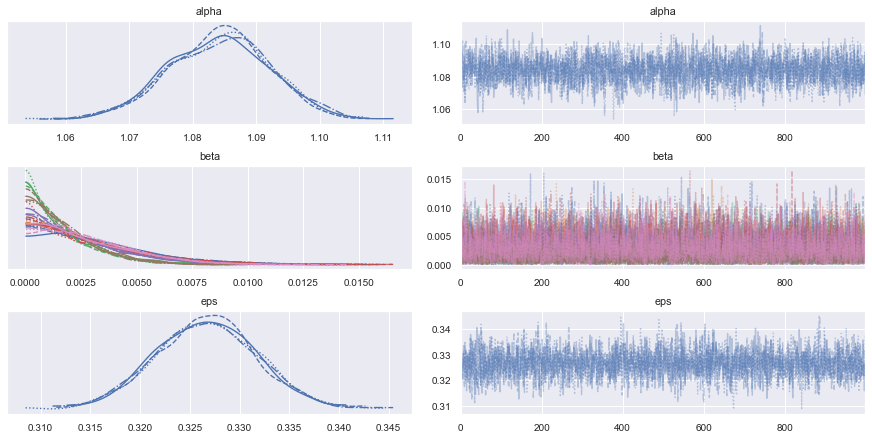

In [102]:
az.plot_trace(trace_halfnorm);

In [103]:
az.summary(trace_halfnorm, var_names = 'beta').set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TV_MONDAY,0.003,0.003,0.0,0.008,0.0,0.0,2277.0,1079.0,1.0
TV_TUESDAY,0.003,0.002,0.0,0.007,0.0,0.0,2745.0,1545.0,1.0
TV_WEDNESDAY,0.002,0.002,0.0,0.005,0.0,0.0,2344.0,1666.0,1.0
TV_THURSDAY,0.003,0.002,0.0,0.007,0.0,0.0,2037.0,1749.0,1.0
TV_FRIDAY,0.002,0.002,0.0,0.006,0.0,0.0,2381.0,1649.0,1.0
TV_SATURDAY,0.002,0.001,0.0,0.004,0.0,0.0,2485.0,1599.0,1.0
TV_SUNDAY,0.003,0.002,0.0,0.007,0.0,0.0,1941.0,1118.0,1.0


In [104]:
# az.plot_forest(trace_normal_halfnorm)

In [105]:
ppc_halfnorm = pm.sample_posterior_predictive(trace_halfnorm, samples=4000, model=model_mlr_halfnorm)

In [106]:
pd.DataFrame(ppc_halfnorm['conversion']).T.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,1.255278,1.525318,0.599546,1.248661,1.871873,0.521859,0.790186,1.305526,1.161689,1.392522,...,1.410299,1.394876,1.349293,0.847943,1.140150,1.287374,1.163901,1.290523,1.205453,0.959039
1,1.290551,1.298989,1.531776,1.584533,1.320577,0.947854,0.275107,1.113117,1.457264,1.006054,...,0.565516,1.120722,1.329101,0.955145,1.081951,0.950681,1.200407,1.417200,0.725380,0.688750
2,0.684396,1.049988,0.962992,1.107618,1.041867,0.796977,1.253616,1.315540,0.658649,1.053222,...,0.965345,1.251230,1.232639,1.344176,0.752728,1.055591,1.112621,1.171939,1.314121,1.170414
3,1.502048,0.908453,1.634403,1.471757,1.657834,0.803881,0.920805,2.068348,0.842891,1.135725,...,1.469695,1.527645,1.535524,1.051667,0.775451,1.306273,1.347122,1.286661,1.120140,2.253807
4,0.993028,0.865818,0.994716,1.318748,1.080775,1.348993,1.064845,1.258840,1.019468,1.066333,...,1.124608,1.187961,0.777907,1.184465,1.186517,1.571715,0.707471,1.029114,1.100852,0.826880


### Using StudentT distribution for Likelihood

In [107]:
with pm.Model() as model_mlr_student:
    # Intercept
    alpha = pm.Normal('alpha', mu=0, sd=10)
    # Slope
    beta = pm.HalfNormal('beta', sd = 2, shape = len(data.columns[:-1]))
    # Error term
    eps = pm.HalfCauchy('eps', 5)
    # Expected value of outcome (ML Regression with vectors)
    mu = alpha + pm.math.dot(x, beta)
    #alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(x_mean, beta))
    
    # define prior for StudentT degrees of freedom
    # InverseGamma has nice properties:
    # it's continuous and has support x ∈ (0, inf)
    nu = pm.InverseGamma("nu", alpha=4, beta=1)
    
    # Likelihood
    conversion = pm.StudentT(
        'conversion', mu= mu, sigma= 10, nu= nu, observed=y)
    
    # posterior
    trace_student = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [nu, eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.


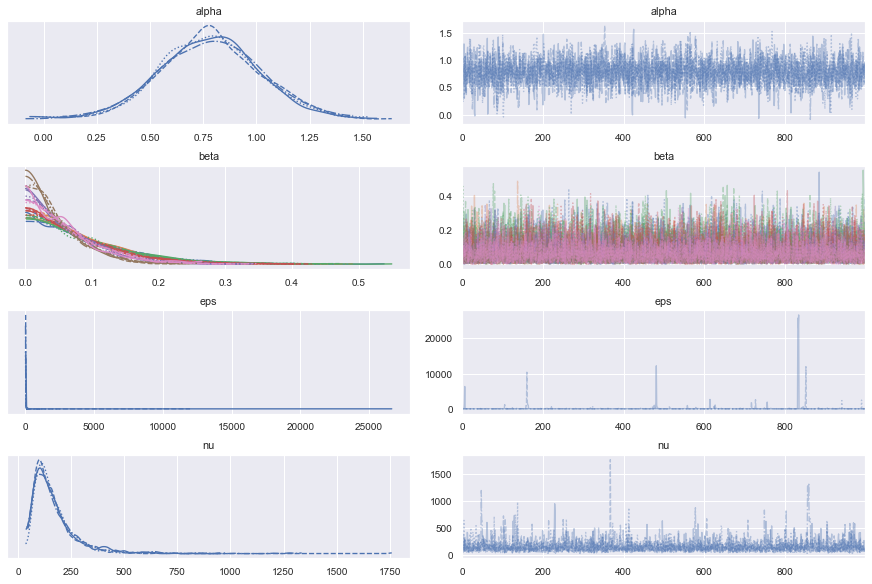

In [108]:
az.plot_trace(trace_student)
plt.show()

In [109]:
az.summary(trace_student, var_names = 'beta').set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TV_MONDAY,0.086,0.074,0.0,0.223,0.001,0.001,2556.0,1609.0,1.0
TV_TUESDAY,0.075,0.063,0.0,0.188,0.001,0.001,2712.0,1420.0,1.0
TV_WEDNESDAY,0.088,0.078,0.0,0.230,0.001,0.001,2209.0,1358.0,1.0
TV_THURSDAY,0.077,0.067,0.0,0.203,0.001,0.001,2031.0,1315.0,1.0
TV_FRIDAY,0.059,0.052,0.0,0.153,0.001,0.001,2975.0,1654.0,1.0
TV_SATURDAY,0.048,0.041,0.0,0.121,0.001,0.000,2119.0,1374.0,1.0
TV_SUNDAY,0.062,0.053,0.0,0.159,0.001,0.001,2307.0,1301.0,1.0


In [110]:
ppc_student = pm.sample_posterior_predictive(trace_student, samples=4000, model=model_mlr_student)

In [111]:
pd.DataFrame(ppc_student['conversion']).T.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,-5.329183,-7.529953,-12.156980,-1.127361,4.721815,-0.846853,11.836317,10.641357,3.786465,18.131172,...,-1.564706,17.296376,-5.968109,-18.531884,-2.806739,5.514254,-5.821188,1.998237,1.779835,-1.457358
1,11.212434,8.086229,-3.121379,-11.665698,4.785194,-2.359199,-9.762772,0.049434,-2.238857,-6.590996,...,2.895514,-5.494595,8.620815,-13.024322,17.226758,13.853882,10.573369,-6.374562,10.724309,14.644804
2,8.976008,15.076851,2.137545,-3.680614,15.499939,-1.078357,-9.214562,1.086360,-10.588581,-0.049417,...,9.643559,10.647846,5.205257,1.370159,-4.321283,-20.919461,-0.831518,-11.250102,-2.741318,-1.037810
3,1.318579,8.954161,-26.186303,8.303053,-12.658981,-3.741270,-0.541885,17.171321,-2.370375,-2.998706,...,-5.383581,22.765475,6.518212,16.282844,24.968086,-12.596628,7.609559,-3.423171,-6.638028,-10.831900
4,-0.333267,14.867594,4.925495,16.768482,12.197104,17.065004,1.307045,13.527213,-10.355371,-2.972468,...,0.862943,-9.729179,3.207347,-16.325655,7.005239,-5.245013,-8.127444,-2.815907,6.853603,-2.530006


## Changing Likelihood to InverseGamma Distribution

In [116]:
with pm.Model() as model_IG:
        # Intercept
        alpha = pm.Normal('alpha', mu=2, sd=10)
        # Slope
        beta = pm.HalfNormal('beta', sd =5, shape = x.shape[1])
        # Error term
        eps = pm.HalfCauchy('eps', 5)
        #v = pm.Exponential('ν', 30)
        #ν = pm.Deterministic('ν', ν_ + 1)
        
        # Expected value of outcome (ML Regression with vectors)
        mu = alpha + pm.math.dot(x, beta)
        #alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(x_mean, beta))

        # Likelihood
        conversion = pm.InverseGamma('conversion', 
                                 mu= mu,
                                 sigma= eps,
                                 alpha=6,
                                 beta=1.5,
                                 observed=y)
        # posterior
        trace_IG = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.


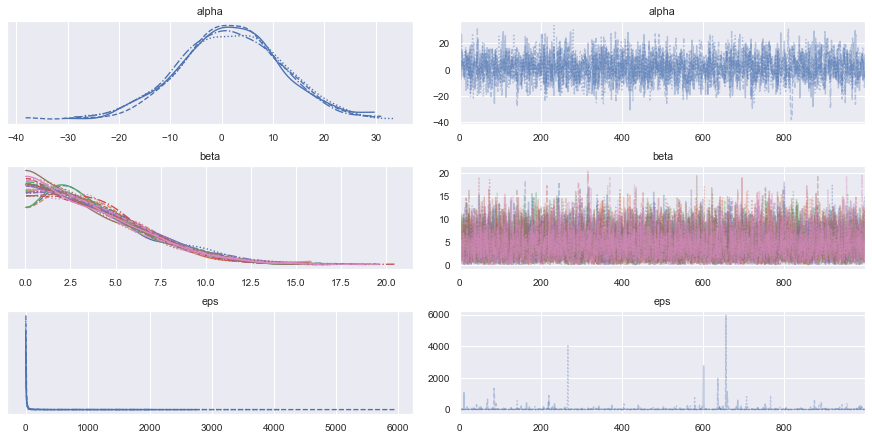

In [117]:
az.plot_trace(trace_IG)
plt.show()

In [118]:
az.summary(trace_IG, var_names ='beta').set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TV_MONDAY,4.075,3.003,0.004,9.520,0.054,0.038,2036.0,1336.0,1.0
TV_TUESDAY,4.013,2.993,0.002,9.359,0.049,0.034,2497.0,1400.0,1.0
TV_WEDNESDAY,3.945,2.919,0.004,9.227,0.054,0.038,1849.0,1212.0,1.0
TV_THURSDAY,4.026,2.989,0.013,9.256,0.053,0.038,2096.0,1335.0,1.0
TV_FRIDAY,3.983,2.964,0.000,9.271,0.059,0.042,1455.0,962.0,1.0
TV_SATURDAY,3.914,3.002,0.000,9.419,0.055,0.039,1762.0,1008.0,1.0
TV_SUNDAY,3.977,3.054,0.002,9.412,0.055,0.039,1852.0,975.0,1.0


In [121]:
ppc_IG = pm.sample_posterior_predictive(trace_IG, samples=4000, model=model_IG)

In [122]:
pd.DataFrame(ppc_IG['conversion']).T.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,0.146431,0.353830,0.195531,0.271490,0.126099,0.178028,0.319493,0.322666,0.289597,0.512032,...,0.120164,0.267926,0.253478,0.379148,0.289795,0.457672,0.348188,0.696650,0.270028,0.393582
1,0.360653,0.157976,0.110725,0.256777,0.378350,0.222505,0.183074,0.307711,0.227385,0.458139,...,0.235690,0.226531,0.241978,0.095050,0.123331,0.443037,0.299543,0.191940,0.624163,0.217511
2,0.269005,0.303044,0.338725,0.191619,0.675345,0.405509,0.560997,0.217670,0.284774,0.558084,...,0.245152,0.507516,0.321542,0.382538,0.466158,0.212953,0.216440,0.186856,0.318651,0.330006
3,0.238682,0.474107,0.476448,0.132081,0.146714,0.155111,0.503792,0.286246,0.185785,0.258694,...,0.246387,0.231286,0.378951,0.168670,0.326891,0.366406,0.319967,0.345984,0.202828,0.448382
4,0.161353,0.206972,0.231034,0.370952,0.258419,0.305193,0.182111,0.296275,0.241356,0.137576,...,0.353714,0.306033,0.460907,0.161487,0.326293,0.232973,0.191367,0.210002,0.157833,0.370765


In [ ]:
# Centering the independent variables in order to minimize correlation btw alpha and beta
# x_mean = x.mean(axis=0, keepdims=True)
# x_centered = x - x_mean 

### Changing Likelyhood function to LogNormal Distributionn 

In [124]:
with pm.Model() as model_mlr_log:
    
    # Intercept
    alpha = pm.Normal('alpha', mu=1, sd=10)
    
    # Slope
    beta = pm.HalfNormal('beta', sd =50, shape = len(data.columns[:-1]))
    
    # Error term
    eps = pm.HalfCauchy('eps', 5)
    
    # Expected value of outcome (ML Regression with vectors)
    mu = alpha + pm.math.dot(x, beta)
    #alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(x_mean, beta))
    
    # Likelihood
    conversion = pm.Lognormal('conversion', mu= mu, sigma= eps, observed=y)
    
    # posterior
    trace_log = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 107 seconds.


In [125]:
# Lets look at intercepts
varnames = ['alpha', 'eps', 'beta']
az.summary(trace_log, var_names = varnames[-1]).set_index(data.columns[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TV_MONDAY,0.002,0.002,0.0,0.005,0.0,0.0,3067.0,2022.0,1.0
TV_TUESDAY,0.002,0.001,0.0,0.004,0.0,0.0,2566.0,1551.0,1.0
TV_WEDNESDAY,0.001,0.001,0.0,0.003,0.0,0.0,2331.0,1252.0,1.0
TV_THURSDAY,0.002,0.002,0.0,0.005,0.0,0.0,2603.0,1458.0,1.0
TV_FRIDAY,0.002,0.001,0.0,0.004,0.0,0.0,2385.0,1616.0,1.0
TV_SATURDAY,0.001,0.001,0.0,0.003,0.0,0.0,2008.0,993.0,1.0
TV_SUNDAY,0.002,0.001,0.0,0.004,0.0,0.0,1937.0,1175.0,1.0


In [126]:
az.summary(trace_log, var_names = varnames[:-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.056,0.005,0.047,0.066,0.0,0.0,3005.0,2689.0,1.0
eps,0.211,0.003,0.205,0.217,0.0,0.0,3706.0,2995.0,1.0


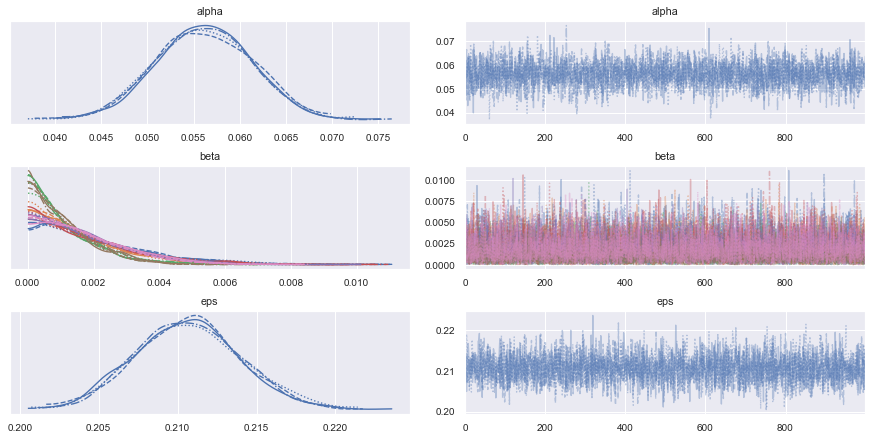

In [127]:
az.plot_trace(trace_log);

In [153]:
ppc_log = pm.sample_posterior_predictive(trace_log, samples=100, model=model_mlr_log)

In [154]:
pd.DataFrame(ppc_log['conversion']).T.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.515097,0.820477,1.008834,1.172197,1.223985,0.779220,0.641149,0.799639,1.170874,1.218602,...,0.778918,1.448336,0.849267,1.156374,1.241181,0.909965,0.885885,1.130270,0.997239,1.034149
1,1.261180,0.827679,0.935604,0.726188,0.949016,0.970842,1.647346,0.928139,1.137501,1.117949,...,1.008175,0.785399,1.180539,0.981342,0.815932,1.213520,1.234718,1.809231,1.301184,1.073327
2,0.933315,1.127500,0.997491,1.092563,1.616234,1.272035,0.931262,0.900121,0.954012,0.932311,...,1.214146,1.165531,0.849964,1.456590,0.946137,1.492045,1.703826,1.190012,0.965500,1.101803
3,1.331857,1.008944,1.223759,0.963293,1.924213,1.047487,0.898656,0.898067,1.063551,1.113050,...,1.226266,0.973908,0.724319,0.921643,1.235684,1.099930,1.226381,0.902834,0.941755,0.744326
4,1.294238,1.189271,0.916764,0.898517,0.766490,0.998419,1.028038,1.159051,0.953802,1.038221,...,1.006385,1.123608,1.158293,1.163902,1.017764,0.813905,0.908313,1.425272,1.424219,1.447867


In [130]:
# az.plot_forest(trace_normal_log)

In [131]:
#check_rhat(trace_log, 1.01)

In [132]:
#az.plot_energy(trace_log)

### Model Comparison

By performing posterior predictive checks, we hope to get a better grasp of the limitations of a model, either to properly acknowledge them, or to attempt to improve the model. Implicit, in the previous statement is the fact that models will not generally reproduce all aspects of a problem equally well. This is not generally a problem given that models are built with a purpose in mind. A posterior predictive check is a way to evaluate a model in the context of that purpose; thus, if we have more than one model, we can use posterior predictive checks to compare them.

In [54]:
# model_formula = 'Conver = '
# for variable in normal_trace_normal.varnames:
#     model_formula += ' %0.2f * %s +' % (np.mean(normal_trace_normal[variable]), variable)
# ' '.join(model_formula.split(' ')[:-1])

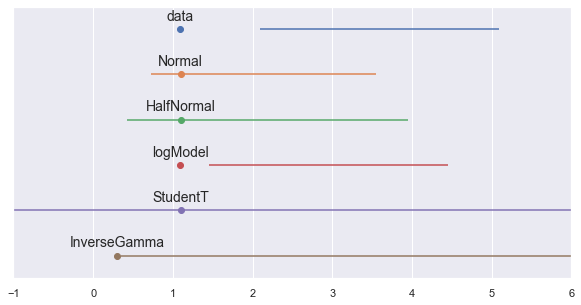

In [133]:
plt.figure(figsize=(10, 5))
ppc_data = [y, 
            ppc_normal['conversion'], 
            ppc_halfnorm['conversion'], 
            ppc_log['conversion'],
            ppc_student['conversion'],
            ppc_IG['conversion']
           ]

labels = ['data', 'Normal', 'HalfNormal', 'logModel', 'StudentT', 'InverseGamma']
for i, d in enumerate(ppc_data):
    mean = d.mean()
    err = np.percentile(d, [0, 100])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
    plt.ylim([-i-0.5, 0.5])
    plt.xlim([-1., 6])
    plt.yticks([])

The preceding diagram shows the mean and the interquartile range (IQR) for the data and for 4 different models
In this diagram, we are averaging over the posterior predictive samples for each model. We can see that the mean is (on average)
well reproduced for 3 models, and that the interquantile range is not very off, but there are some small differences that, in a real problem, could be worthy of some attention. 

### Dispersion of both the mean and the interquartile range, as opposed to their mean values

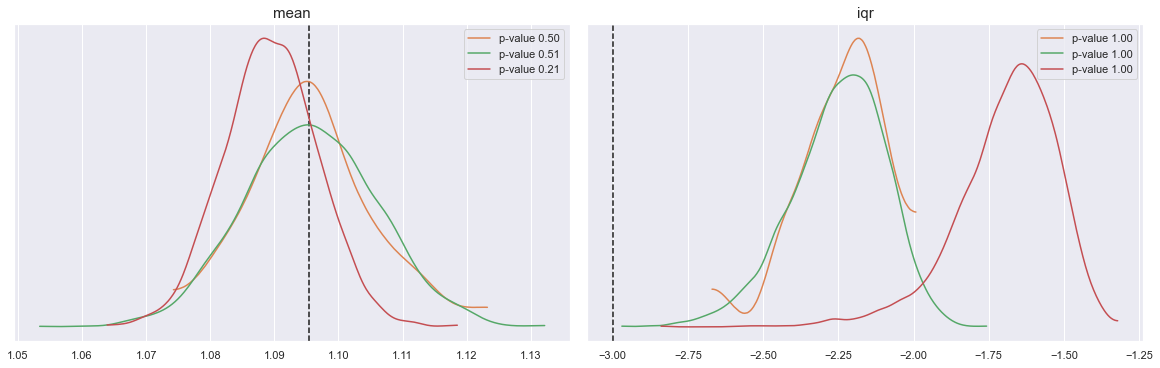

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

def iqr(k, a=0):
    # calculate range
    return np.subtract(*np.percentile(k, [0, 100], axis=a))


for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    
    for d_sim, c in zip([ppc_normal['conversion'], 
                         ppc_halfnorm['conversion'],
                         ppc_log['conversion']],
                        ['C1', 'C2', 'C3']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c},
        label=f'p-value {p_value:.2f}', ax=ax[idx])
        ax[idx].set_title(func.__name__, size =15)
        ax[idx].set_yticks([])
        ax[idx].legend()

The black dashed line represents the statistic computed from the data (either the mean or the IQR). Because we have a single dataset we have a single value for the statistic (and not a distribution). The curves (using the same color code from Previous Graph) represent the distribution of the mean (left panel) or interquartile range (right panel) that was computed from the posterior predictive samples.

Compute such P-values by comparing the simulated data to the actual data. For all sets, compute a summary statistic (the mean or IQR, in this example), and then we count the proportion of times the summary statistics from the simulation is equal or greater than the one computed from the data.`

 If the data and simulation agrees, we should expect a -value around 0.5, otherwise we are in the presence of a biased posterior predictive distribution.

Bayesian's P -values are just a way to get a number measuring the fit of a posterior predictive check.

<img src="../imgs/Bayesin p-value.png"/>

Getting the probability of getting a simulated statistic  equal or more extreme than a statistic from the data . Here,  can be almost anything that provides a summary of the data. The mean for the left panel and the standard deviation for the right panel.  should be chosen while taking into account the question that motivated the inference in the first place.

These -values are Bayesian because, for the sampling distribution, we are using a posterior predictive distribution. Also notice that we are not conditioning on any null hypothesis; in fact, we have the entire posterior distribution of  and we are conditioning on the observed data. 